# DATA MINING PROJECT: Analysis of a Supermarket’s Customers
## 2.1) Clustering Analysis: K-means
### *Antonio Strippoli, Valerio Mariani*

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
from math import ceil
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('mode.chained_assignment', None)

In [2]:
def plot(ax, folder="clustering_kmeans", filename="", figsize=(6.4, 4.8)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    plt.tight_layout()
    if filename:
        path = os.path.join("..", "report", "imgs", folder)
        if not os.path.exists(path):
            os.mkdir(path)
        plt.savefig(os.path.join(path, filename))
    plt.show()
    plt.close()

def plt_radar(df: pd.DataFrame, colors=[], ylabels=True, legend_title="", folder="clustering_kmeans", filename=""):
    """Represent a DataFrame using a radar plot.
    """
    # Number of variable
    categories=list(df.index)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    if ylabels:
        ax.set_rlabel_position(0)
        ylim = ceil(df.max().max())
        ticks = list(range(0,ylim,5))
        ticks_str = list(map(lambda x: str(x), ticks))
        plt.yticks(ticks, ticks_str, color="grey", size=7)
        plt.ylim(0,ylim)

    # PART 2: Add plots
    for i, c in enumerate(df.columns):
        # Ind1
        values = list(df[c])
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=1, linestyle='solid', label=c)
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    # Add legend and plot
    plt.legend(title=legend_title, loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plot(None, folder=folder, filename=filename)

In [3]:
# Load dataset for clustering
cdf = pd.read_csv("customer_profilation.csv", index_col=0)

### Definition of attributes employed for clustering and best k value search

In [ ]:
def cluster_score(X, k):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_

    # Values
    inertia = -1 * kmeans.inertia_ / 100
    sil = silhouette_score(X, kmeans.labels_) * 100
    k_weight = -1 * (k / 2)**2
    return inertia + sil + k_weight

In [ ]:
cdf.drop(columns=['ItemPref','MainCountry','WeekDayPref','WeekMonthPref','PReturn'], inplace=True)

combos = list(combinations(cdf.columns.array, 3))

score = -100000
best = []
best_k = 0
for i, combo in enumerate(combos):
    print(i, "/", len(combos))
    clear_output(wait=True)
    new_cdf = cdf[list(combo)]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(new_cdf.values)
    
    for k in range(3, 7):
        new_score = cluster_score(X, k)
        if new_score > score:
            score = new_score
            best = list(combo)
            best_k = k

print(best)
print(best_k)
print(score)

In [4]:
# First attempts
attr_cluster = ['Recency', 'TotItems', 'Monetary']
attr_cluster = ['Recency', 'TotItems', 'MaxSale']
attr_cluster = ['Monetary', 'TotItems', 'MeanItemSale'] # Best of 3
attr_cluster = ['Frequency', 'TotItems', 'MeanItems', 'MeanBasketSale'] # Best of 4

# We choosed these 3 attributes, since they usually classify very well customers
attr_cluster = ['Recency', 'Frequency', 'Monetary']
cdf_cluster = cdf[attr_cluster]

# Normalize values
scaler = StandardScaler() # MinMaxScaler
X = scaler.fit_transform(cdf_cluster.values)

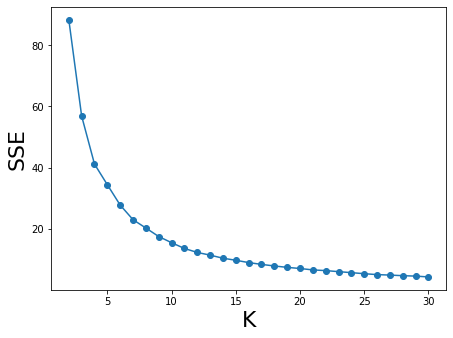

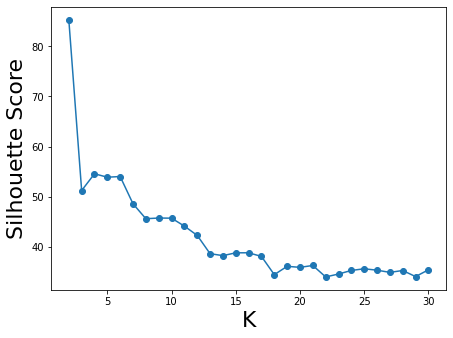

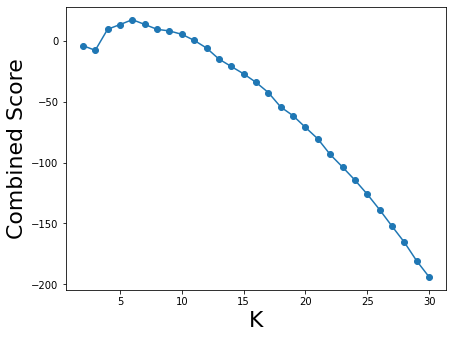

17.25964156541746


In [5]:
# Elbow Method: select best value of K based on SSE and Silhouette Score
max_k = 30
sse_list = []
sil_list = []
sse_sil_list = []
for k in range(2, max_k+1):
    # Try to clusterize with current value of k
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100)
    kmeans.fit(X)
    
    # Save scores
    inertia = -1* kmeans.inertia_ / 100
    sil = silhouette_score(X, kmeans.labels_) * 100
    k_weight = -1*(k / 2)**2

    sse_list.append(-inertia)
    sil_list.append(sil)
    sse_sil_list.append(inertia + sil + k_weight)

# Plot scores
plt.plot(range(2, len(sse_list) + 2), sse_list, marker='o')
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plot(None, filename="SSE")

plt.plot(range(2, len(sil_list) + 2), sil_list, marker='o')
plt.ylabel('Silhouette Score', fontsize=22)
plt.xlabel('K', fontsize=22)
plot(None, filename="Silhouette")

plt.plot(range(2, len(sse_sil_list) + 2), sse_sil_list, marker='o')
plt.ylabel('Combined Score', fontsize=22)
plt.xlabel('K', fontsize=22)
plot(None, filename="Combined_Score")

print(max(sse_sil_list))

### Clusterization, distribution of the choosed attributes, analysis of the centroids

In [6]:
# We choosed 6 as our number of clusters, proceede with the clusterization
kmeans = KMeans(n_clusters=5, init="k-means++", n_init=100, max_iter=1000)
kmeans.fit(X)

sse = round(kmeans.inertia_, 2)
sil = round(silhouette_score(X, kmeans.labels_), 2)
db = round(davies_bouldin_score(X, kmeans.labels_), 2)
print("SSE:", sse)
print("Silhouette:", sil)
print("Davies Bouldin:", db)

# Save centroids
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Define a new colormap to employ in the visualizations
colors = np.array([
    (219, 42, 42, 255), # Red
    (219, 116, 42, 255), # Orange
    (80, 219, 42, 255), # Green
    (42, 219, 213, 255), # Cyan
    (42, 48, 219, 255), # Blue
])
colors = colors / 255.0
cm = LinearSegmentedColormap.from_list('clusters_6', colors, N=5)

SSE: 3439.53
Silhouette: 0.54
Davies Bouldin: 0.66


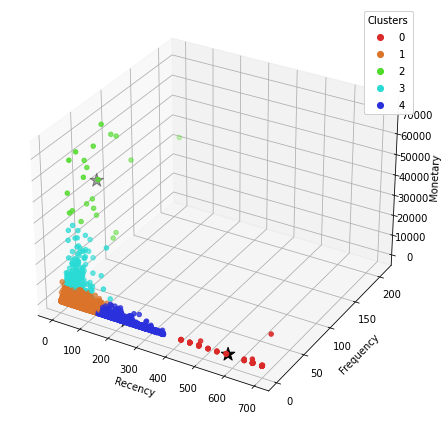

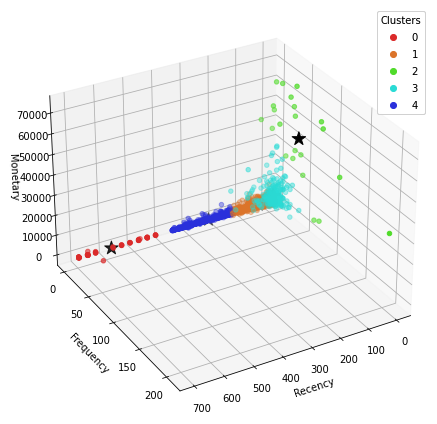

In [7]:
# 3D Scatter plot of the attributes clusterized
def cluster_scatter_3d(view_init=None, filename=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    c1, c2, c3 = attr_cluster
    scatter = ax.scatter3D(cdf_cluster[c1], cdf_cluster[c2], cdf_cluster[c3], c=kmeans.labels_, label=kmeans.labels_, s=20, cmap=cm)
    ax.scatter3D(centers[:, 0], centers[:, 1], centers[:, 2], s=200, marker='*', c='k')
    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(c3)

    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    if view_init:
        ax.view_init(*view_init)

    plot(None, figsize=(6,6), filename=filename)

cluster_scatter_3d(filename="Attr_3D")
cluster_scatter_3d(filename="Attr_3D_rot", view_init=(30,60))

In [ ]:
# Get normalized centers
norm_centers = kmeans.cluster_centers_

# Centroids plotted using parallel coordinates
for i in range(0, len(norm_centers)):
    plt.plot(norm_centers[i], marker='o', label=str(i), color=colors[i])
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(cdf_cluster.columns)), cdf_cluster.columns, fontsize=18)
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plot(None, filename="Parallel_Coordinates")

# Centroids using Radar Plot
centroids_df = pd.DataFrame(norm_centers, columns=attr_cluster).T
plt_radar(centroids_df, ylabels=False, legend_title="Clusters", colors=colors, filename="Radar")

### Further clusters analysis

In [ ]:
# Add Cluster Labels to the dataset
cdf = pd.read_csv("customer_profilation.csv", index_col=0)
cdf['ClusterLabels'] = kmeans.labels_

In [ ]:
# Barplot of Clusters distribution
plot(cdf.groupby('ClusterLabels')['Recency'].count().plot.bar(), filename="Distribution")

In [ ]:
# PlotBox of attributes utilized for clusterization
plot(sn.boxplot(x='ClusterLabels', y='Recency', data=cdf), filename="Recency_BP")
plot(sn.boxplot(x='ClusterLabels', y='Frequency', data=cdf), filename="Frequency_BP")
plot(sn.boxplot(x='ClusterLabels', y='Monetary', data=cdf), filename="Monetary_BP")

In [ ]:
# PReturn distribution
# Result: Gruppo 1 ha PReturn più alta e recency alta (non vengono da un po' ed hanno dato via parecchia roba)
preturn_mean = cdf[['ClusterLabels', 'PReturn']].groupby('ClusterLabels').agg('mean')
plot(preturn_mean.plot.bar(), filename="PReturn")

In [ ]:
# Preferred item for each cluster
df = pd.read_csv('customer_supermarket_2.csv', index_col=0, parse_dates=["PurchaseDate"])
preferred_items = cdf[['ClusterLabels', 'ItemPref']].groupby('ClusterLabels').agg(lambda x: x.mode().iloc[0])
preferred_items['ProdDescr'] = [df[df['ProdID'] == element]['ProdDescr'].iloc[0] for element in preferred_items['ItemPref']]
preferred_items

In [ ]:
# Populars attributes of each cluster: MainCountry
cdf[['ClusterLabels', 'MainCountry']].groupby('ClusterLabels').agg(lambda x: x.mode().iloc[0])

In [ ]:
# Populars attributes of each cluster: WeekDayPref
cdf[['ClusterLabels', 'WeekDayPref']].groupby('ClusterLabels').agg(lambda x: x.mode().iloc[0])

In [ ]:
# Populars attributes of each cluster: WeekMonthPref
cdf[['ClusterLabels', 'WeekMonthPref']].groupby('ClusterLabels').agg(lambda x: x.mode().iloc[0])

In [ ]:
# Entropies plot box
plot(sn.boxplot(x='ClusterLabels', y='E-Qta', data=cdf), filename="EQta_BP")
plot(sn.boxplot(x='ClusterLabels', y='E-Sale', data=cdf), filename="ESale_BP")

In [ ]:
# Popular mean item sale
mean_item_sale = cdf[['ClusterLabels', 'MeanItemSale']].groupby('ClusterLabels').agg('mean')
plot(mean_item_sale.plot.bar(), filename="MeanItemSale")